# **Functional Approach to Querying the IMDb Database**

The Internet Movie Database (IMDb) is an online database of information related to films, television programs, home videos, and video games. Users can access details about movies, TV shows, actors, directors, production crew, and more on IMDb. It's widely used by industry professionals, film enthusiasts, and general audiences for research, reviews, ratings, and recommendations.

A subset of the IMDb data was used to create an SQLite database file `imdb.db` that contains data the available data through 3/27/2022. This project evaluates broader rating influences, particularly the effect of director experience and runtime length on a film’s rating. To do this, we define two SQL-driven Python functions: `genres(dbcon, genre, min_rating)` and `rating_by_runtime(dbcon, min_minutes, max_minutes)`.

The first function, `genres`, identifies the top directors within a specific genre and examines whether their experience (measured by the number of titles they directed) relates to the average rating of their work. It produces:

- A table of the top 10 highest-rated directors in the selected genre,

- Titles' average ratings of genre,

- A table showing how many titles each director has directed,

- A barplot comparing directing experience among these top performers.

This allows us to explore whether experience is rewarded with higher ratings and how director performance compares across genres.

The second function, `rating_by_runtime`, analyzes the relationship between runtime categories (`Short`, `Medium`, `Long`) and average movie ratings. Using SQL classification and aggregation, it computes:

- Average rating by runtime group,

- Average runtime within the selected range,

- A barplot showing how ratings vary across runtime lengths.

This helps determine whether longer films tend to receive higher ratings, or whether runtime has only a minimal effect.

In [40]:
#Import necessary libraries
import sqlalchemy as sa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [41]:
#Connect to the database
cstring = 'sqlite+pysqlite:///imdb.db'
engine = sa.create_engine(cstring)
connection = engine.connect()

In [42]:
# Overview of the genres in the database
def genres_list(dbcon):
  pyquery = """ 
  SELECT DISTINCT(genres) 
  FROM titles"""
  pandas_table = pd.read_sql_query(pyquery, con = dbcon)
  return pandas_table

print(genres_list(connection))


                            genres
0                Documentary,Short
1                  Animation,Short
2         Animation,Comedy,Romance
3                     Comedy,Short
4                            Short
...                            ...
2303       Biography,Crime,Fantasy
2304       Drama,Horror,Reality-TV
2305         Biography,Crime,Music
2306   Mystery,Reality-TV,Thriller
2307  Musical,Reality-TV,Talk-Show

[2308 rows x 1 columns]


# **Function 1: Top directors of specific genre relating with experience**

In [43]:
def genres(dbcon, genre, min_rating):
  #Define a SQL query needed for the table output of the top 10 directors of a specific movies with named binding
  pyquery= """ 
  SELECT name , AVG(rating) as average_rating
  FROM titles
  LEFT JOIN crew USING (title_id)
  LEFT JOIN people USING (person_id)
  LEFT JOIN ratings USING (title_id)
  WHERE category ='director' and genres LIKE '%' || :genre || '%' AND rating >= :min_rating
  GROUP BY name
  ORDER BY average_rating DESC
  LIMIT 10
  """
  df = pd.read_sql_query(pyquery, con = dbcon, params = {'genre':genre, 'min_rating':min_rating})

  director_list = df['name'].tolist() #Extracting the list of directors from the dataframe

  print("Top 10 directors of a specific movies")
  print("=======================================")
  print(df)
  print("=======================================")

  #If no directors found

  if len(director_list) ==0:
    print("No directors found for this genre with the minimum rating.")
    return df, None
  
  #Compute average title's rating of top 10 directors of specific genre:
  top_average_rating = np.mean(df['average_rating'])
  print("The average title' rating of top 10 directors of "+ genre +' is ' +str(top_average_rating))
  print("=======================================")
  ###############################################################################################
 # Build placeholder

  placeholder = ",".join(["?"] *len(director_list))

  #Define a SQL query needed for the bar graph comparing number of films the directors have made in their career with positional binding

  pyquery2 = f"""
  SELECT name, COUNT(title_id) as num_title
  FROM titles
  LEFT JOIN crew USING(title_id)
  LEFT JOIN people USING (person_id)
  LEFT JOIN ratings USING (title_id)
  WHERE genres LIKE '%' || ? || '%'
  AND category ='director' 
  AND name IN ({placeholder})
  GROUP BY name
  ORDER BY num_title DESC
  LIMIT 5 
  """
  params = tuple([genre]+ director_list)
  df2 = pd.read_sql_query(pyquery2, con = dbcon, params = params)

  print("Number of films directors with top-ranking titles have directed")
  print("=======================================")
  print(df2)

  #################################################################################################
  #Plotting the bar graph of number of titles directed by each director

  plt.bar(df2['name'], df2['num_title'])
  plt.xlabel('Directors')
  plt.ylabel('Total number of titles directed')
  plt.title('Total number of titles directed by top directors')
  plt.xticks(rotation=45)  # rotate labels
  plt.tight_layout() 
  plt.show()
  


### Testcase 1: Animation with Min rating = 0

Top 10 directors of a specific movies
                name  average_rating
0       Mpolypragmon       10.000000
1      Kouki Aoshima        9.900000
2      Ali Derakhshi        9.900000
3        Andy Luckey        9.825000
4   Ricardo Laganaro        9.800000
5      Milo Ferguson        9.800000
6  Dimitris Gaitanis        9.741667
7        Mark Haynes        9.733333
8     Pedro Siaretta        9.700000
9        John Landis        9.700000
The average title' rating of top 10 directors of Animation is 9.81
Number of films directors with top-ranking titles have directed
                name  num_title
0  Dimitris Gaitanis         12
1        Mark Haynes         11
2      Ali Derakhshi          7
3        Andy Luckey          4
4        John Landis          1


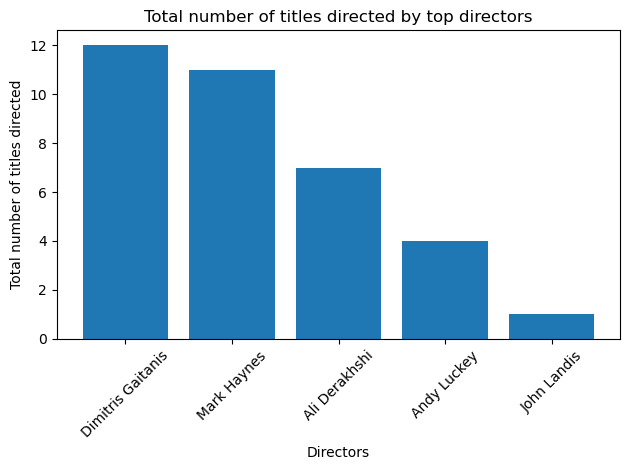

In [44]:

genres(connection, "Animation",0)

#### Analysis of the output
**Rating Consistency Among Top Directors:** The ratings of the top directors are extremely close, with differences of only about 0.1 between most of them, with the average rating of 9.81 for all top animations.
This tight clustering suggests that in this genre, the highest-performing directors reach a very similar level of quality, and audience ratings are fairly consistent across their work.

**Relationship Between Productivity and Ratings:** Many of the directors who appear in the top-10 for average rating are also the ones who have directed the most titles.
This pattern supports the idea that higher productivity may contribute to higher ratings, since directing more titles allows these directors to build experience, refine their style, and produce work that is consistently well-received.

**Exceptions: High Ratings With Low Output:** A few directors with only one or very few films still appear near the top of the ratings.
These cases show that exceptional talent can appear even without a long history of work, but their ratings are also less reliable, since a single highly rated film may simply be a “lucky hit” rather than evidence of consistent quality.

**Conclusion:** The results suggest that in this genre, both extensive experience and standout individual talent can lead to high audience ratings.
This creates a balance where experienced directors tend to be consistently strong, while a few newcomers can still break through with exceptional work.

### Testcase 2: Horror with Min rating of 7

Top 10 directors of a specific movies
                name  average_rating
0      V. Blake Rose            10.0
1         Tulio Beat            10.0
2      Shirin Jabiev            10.0
3  Shashikant Sharma            10.0
4       Peter Dranga            10.0
5          Omar Amir            10.0
6     Lorenzo Pomari            10.0
7       Laume Conroy            10.0
8     João Folharini            10.0
9     John J. Kerecz            10.0
The average title' rating of top 10 directors of Horror is 10.0
Number of films directors with top-ranking titles have directed
             name  num_title
0    Peter Dranga          6
1    Laume Conroy          3
2  John J. Kerecz          1
3  João Folharini          1
4  Lorenzo Pomari          1


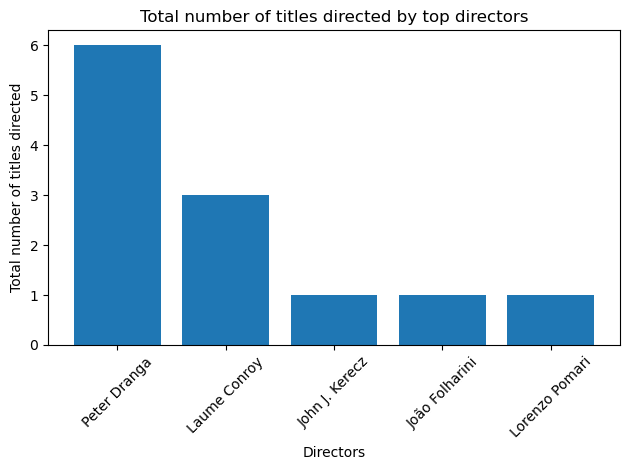

In [45]:
genres(connection, "Horror", 7)

#### Analysis of the output

**Comparison of Horror Results to Animation:** The `Horror` genre shows a similar pattern to `Animation` in that top directors all achieve extremely high ratings, and productivity varies across individuals. However, one key difference stands out: the average rating of the top 10 Horror directors is 10.0, which is higher than the 9.81 average for Animation. This suggests that the highest-ranking Horror titles tend to generate even stronger audience approval. While some Horror directors have many titles (e.g., Peter Dranga with six), others achieve perfect ratings with only one or two films, showing both experience and standout talent can succeed. Overall, the peak performance in Horror appears more intense than in Animation, indicating that top Horror films may resonate more strongly with viewers

# **Function 2: Effect of runtime on Rating of the titles**

In [46]:
def rating_by_runtime(dbcon, min_minutes, max_minutes):
  pyquery = """
  SELECT c.runtime_category, AVG(c.rating) as average_category_rating, AVG(c.runtime_minutes) as average_runtime
  FROM(
  SELECT primary_title, rating, runtime_minutes,
  CASE
    WHEN (runtime_minutes <= 90) THEN 'Short'
    WHEN (runtime_minutes BETWEEN 90 AND 180) THEN 'Medium'
    ELSE 'Long' 
  END AS runtime_category
  FROM titles
  LEFT JOIN ratings USING (title_id)
  WHERE runtime_minutes BETWEEN :min_minutes and :max_minutes) AS c
  GROUP BY runtime_category
  ORDER BY average_runtime DESC
  """
  df = pd.read_sql_query(pyquery, con = dbcon, params = {'min_minutes': min_minutes, 'max_minutes': max_minutes})

  print(df)

  plt.bar(df['runtime_category'], df['average_category_rating'])
  plt.xlabel("Runtime Category")
  plt.ylabel("Average Runtime (in minutes)")
  plt.show()
  return df
  
  



### Testcase

  runtime_category  average_category_rating  average_runtime
0             Long                 6.962453       191.163581
1           Medium                 6.293886       113.663948
2            Short                 6.063416        86.310320


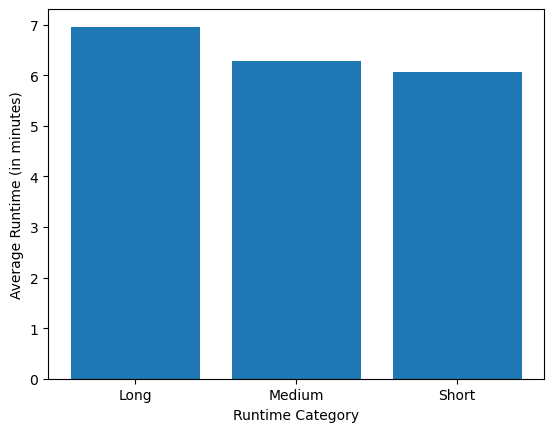

  runtime_category  average_category_rating  average_runtime
0             Long                 6.962453       191.163581
1           Medium                 6.293886       113.663948
2            Short                 6.063416        86.310320


In [47]:
print(rating_by_runtime(connection, 80, 200))

#### Analysis of the Output:


**Rating Consistency Among Runtime Categories:** The average ratings for Short, Medium, and Long films fall within a narrow range (roughly 6.0–7.0), showing that audience ratings do not change dramatically with runtime. This clustering suggests that runtime alone is not a strong determinant of movie quality, and films of all lengths tend to receive similar levels of audience approval.

**Longer Films Show Slightly Higher Ratings:** Long movies have the highest average rating among the three groups, reflecting that longer films often have larger budgets, more developed stories, or more experienced production teams, which can contribute indirectly to higher audience ratings.

**Runtime Is Correlated With, Not Causal of Higher Ratings:** Although longer films tend to have higher ratings, this relationship does not imply causation. Other factors—such as production resources, genre tendencies, or studio influence—likely explain the higher ratings observed for longer films. Runtime serves more as a signal of these attributes rather than a direct driver of quality.